In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.appName('Read CSV File into DataFrame').getOrCreate()

In [7]:
data=spark.read.csv(r"C:\Users\16478\Desktop\BigData\Lab4\Live.csv", sep=',',inferSchema=True, header=True)

In [8]:
data.show(5)

+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|           status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|Column1|Column2|Column3|Column4|
+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|246675545449582_1...|      video|  4/22/2018 6:00|          529|         512|       262|      432|       92|       3|        1|       1|         0|   null|   null|   null|   null|
|246675545449582_1...|      photo| 4/21/2018 22:45|          150|           0|         0|      150|        0|       0|        0|       0|         0|   null|   null|   null|   null|
|246675545449582_1...|      video|  4/21/2018 6:17|          227|         236|        57|      

In [9]:
data.printSchema()

root
 |-- status_id: string (nullable = true)
 |-- status_type: string (nullable = true)
 |-- status_published: string (nullable = true)
 |-- num_reactions: integer (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- num_shares: integer (nullable = true)
 |-- num_likes: integer (nullable = true)
 |-- num_loves: integer (nullable = true)
 |-- num_wows: integer (nullable = true)
 |-- num_hahas: integer (nullable = true)
 |-- num_sads: integer (nullable = true)
 |-- num_angrys: integer (nullable = true)
 |-- Column1: string (nullable = true)
 |-- Column2: string (nullable = true)
 |-- Column3: string (nullable = true)
 |-- Column4: string (nullable = true)



In [10]:
#removing NA Values

In [11]:
data = data.drop('Column1','Column2','Column3','Column4')

In [12]:
data

DataFrame[status_id: string, status_type: string, status_published: string, num_reactions: int, num_comments: int, num_shares: int, num_likes: int, num_loves: int, num_wows: int, num_hahas: int, num_sads: int, num_angrys: int]

In [13]:
#Removing duplicate rows

In [14]:
data=data.dropDuplicates()
data.show()

+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|           status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|246675545449582_1...|      video|   8/8/2017 5:13|          571|         888|       107|      459|      107|       1|        1|       1|         2|
|246675545449582_1...|      photo|  3/11/2017 8:04|          515|          10|         0|      505|        9|       0|        1|       0|         0|
|246675545449582_1...|      video| 2/10/2017 22:58|           88|           1|         0|       87|        1|       0|        0|       0|         0|
|246675545449582_1...|      photo|   1/6/2017 5:10|          139|          14|         0|      138|       

drop variable columns as it will be not used for clustering

In [15]:
data = data.drop('status_id','status_published')

In [16]:
data.show(1)

+-----------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|status_type|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+-----------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|      video|          571|         888|       107|      459|      107|       1|        1|       1|         2|
+-----------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
only showing top 1 row



In [17]:
feature_col=['num_reactions','num_comments','num_shares','num_likes','num_loves','num_wows','num_hahas','num_sads','num_angrys','y_target']

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col


In [19]:
indexer = StringIndexer(inputCol='status_type', outputCol='y_target')
i_model=indexer.fit(data)
i_data=i_model.transform(data)

In [20]:
i_data.show(1)

+-----------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+--------+
|status_type|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|y_target|
+-----------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+--------+
|      video|          571|         888|       107|      459|      107|       1|        1|       1|         2|     1.0|
+-----------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+--------+
only showing top 1 row



In [21]:
assemble=VectorAssembler(inputCols= feature_col, outputCol='features')
#a_data=assemble.transform(i_data)

In [22]:
scale=StandardScaler(inputCol='features',outputCol='scaled_features',withStd=True, withMean=True)
#s_model=scale.fit(a_data)
#s_data=s_model.transform(a_data)
#s_data.show(1)

In [23]:
silhouette_scores = []
wssse_scores = []
for i in range(2,10):
    kmeans= KMeans(k=i, seed=1)
    pipeline = Pipeline(stages=[assemble,scale,kmeans])
    model = pipeline.fit(i_data)
    predictions = model.transform(i_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    wssse = model.stages[2].summary.trainingCost
    wssse_scores.append(wssse)
    pred = predictions.withColumn("prediction", col("prediction").cast("double"))
    #evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y_target", metricName="accuracy")
    #accuracy = evaluator.evaluate(pred)
    accuracy= predictions.filter(predictions['prediction'] == predictions['y_target']).count() / (predictions.count())
    print("***"*10)
    print("Silhouette score for k=%d: %f" % (i, silhouette)) 
    print("wssse score for k=%d: %f" % (i, wssse)) 
    print("Accuracy for k=%d: %f" % (i, accuracy*100))
    print("***"*10)

******************************
Silhouette score for k=2: 0.956341
wssse score for k=2: 4839823206.131467
Accuracy for k=2: 62.623232
******************************
******************************
Silhouette score for k=3: 0.905623
wssse score for k=3: 2692041220.507795
Accuracy for k=3: 60.708673
******************************
******************************
Silhouette score for k=4: 0.911592
wssse score for k=4: 2079119591.550163
Accuracy for k=4: 60.865838
******************************
******************************
Silhouette score for k=5: 0.889869
wssse score for k=5: 1462768285.310793
Accuracy for k=5: 58.836977
******************************
******************************
Silhouette score for k=6: 0.878393
wssse score for k=6: 1164758774.117053
Accuracy for k=6: 58.794113
******************************
******************************
Silhouette score for k=7: 0.815348
wssse score for k=7: 1046269037.779072
Accuracy for k=7: 57.779683
******************************
****************

Text(0, 0.5, 'cost')

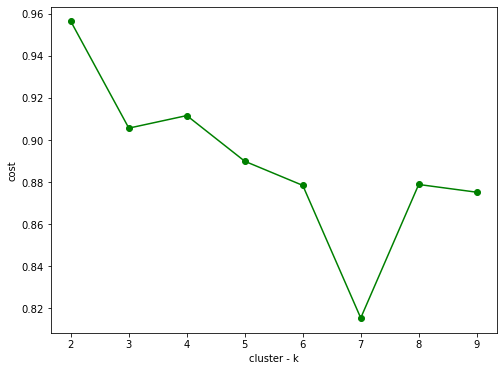

In [142]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_scores,marker='o',color='green')
ax.set_xlabel('cluster - k')
ax.set_ylabel('cost')

From the above elbow method, we can say that with k = 3 is the optimal number of clusters

Text(0, 0.5, 'cost')

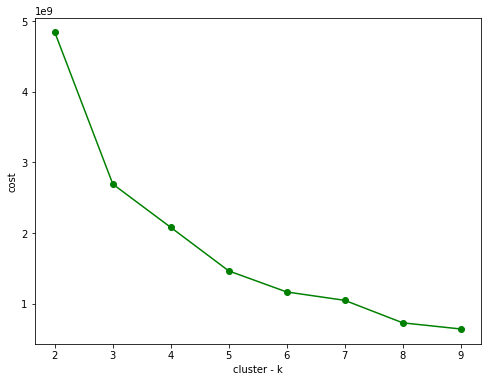

In [143]:
#Visualizing the wssse scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),wssse_scores,marker='o',color='green')
ax.set_xlabel('cluster - k')
ax.set_ylabel('cost')

From the above elbow method, we can say that with k = 3 or 5 as the optimal number of clusters

In [100]:
label=[row.y_target for row in i_data.select("y_target").collect()]

In [174]:
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#from pyspark.sql.functions import col

#pred = predictions.withColumn("prediction", col("prediction").cast("double"))
#evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y_target", metricName="accuracy")
#accuracy = evaluator.evaluate(pred)

# Print the accuracy
#print("Accuracy = {:.2f}%".format(accuracy * 100))

In [24]:
gmm_wssse = []
gmm_silhouette = []

for k in range(2, 10):
    gmm = GaussianMixture().setK(k).setSeed(1)
    gmm_pipeline = Pipeline(stages=[assemble,scale,gmm])
    model_gmm = gmm_pipeline.fit(i_data)
    predictions_gmm = model_gmm.transform(i_data)
    evaluator_gmm = ClusteringEvaluator()
    gmm_silhou = evaluator_gmm.evaluate(predictions_gmm)
    gmm_silhouette.append(gmm_silhou)
    gmm_ws = model_gmm.stages[2].summary.logLikelihood
    gmm_wssse.append(gmm_ws)
    pred_gmm = predictions_gmm.withColumn("prediction", col("prediction").cast("double"))
    #evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y_target", metricName="accuracy")
    #accuracy = evaluator.evaluate(pred_gmm)
    accuracy= predictions_gmm.filter(predictions_gmm['prediction'] == predictions_gmm['y_target']).count() / (predictions_gmm.count())
    print("***"*10)
    print("Silhouette score for k=%d: %f" % (k, gmm_silhou)) 
    print("wssse score for k=%d: %f" % (k, gmm_ws)) 
    print("Accuracy for k=%d: %f" % (k, accuracy*100))
    print("***"*10)

******************************
Silhouette score for k=2: 0.861018
wssse score for k=2: -205116.404800
Accuracy for k=2: 30.718674
******************************
******************************
Silhouette score for k=3: 0.830150
wssse score for k=3: -196866.392619
Accuracy for k=3: 59.165595
******************************
******************************
Silhouette score for k=4: -0.408266
wssse score for k=4: -191123.577946
Accuracy for k=4: 3.471925
******************************
******************************
Silhouette score for k=5: -0.372053
wssse score for k=5: -186719.389573
Accuracy for k=5: 7.343906
******************************
******************************
Silhouette score for k=6: -0.341483
wssse score for k=6: -183133.859694
Accuracy for k=6: 26.432347
******************************
******************************
Silhouette score for k=7: -0.627633
wssse score for k=7: -180102.279532
Accuracy for k=7: 58.051150
******************************
******************************
S

Text(0, 0.5, 'cost')

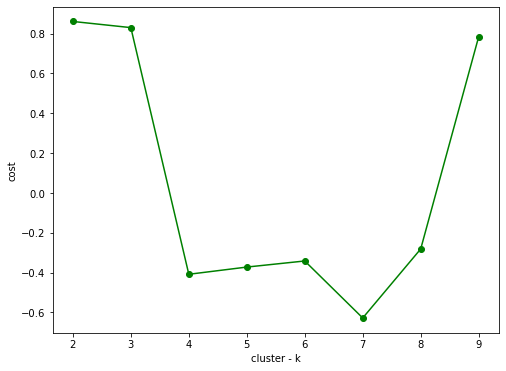

In [152]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),gmm_silhouette,marker='o',color='green')
ax.set_xlabel('cluster - k')
ax.set_ylabel('cost')

From the above elbow method, we can say that with k = 4 as the optimal number of clusters

Text(0, 0.5, 'cost')

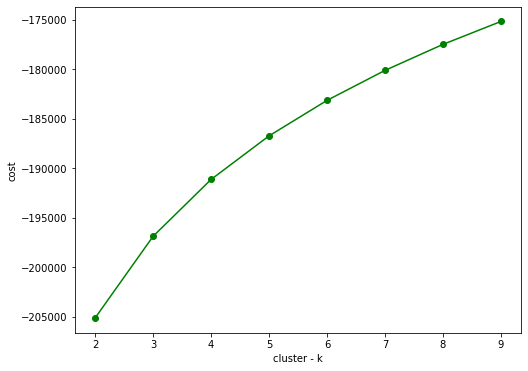

In [148]:
#Visualizing the WSSSE scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),gmm_wssse,marker='o',color='green')
ax.set_xlabel('cluster - k')
ax.set_ylabel('cost')

From the above elbow method, we can say that with k = 3 as the optimal number of clusters

#Compare Clustering models

For k-means clustering, the silhouette scores are higher for all values of k, which indicates better clustering quality. The wssse scores also show a decreasing trend as the number of clusters increases, indicating that the clusters are becoming more compact.

For GMM clustering, the silhouette scores are lower for all values of k, indicating that the clusters are less distinct. The wssse scores are negative, which is not a good sign of clustering quality

Overall, k-means clustering seems to have performed better.

In [282]:
centroid = model_gmm.stages[-1].gaussiansDF

In [28]:
distances = model_gmm.stages[-1]('features').rdd \
    .map(lambda x: (x['prediction'], x['features'])) \
    .groupByKey() \
    .flatMap(lambda x: [(x[0], (xi - model.gaussians[x[0]].mean).dot(model.gaussians[x[0]].invCov).dot((xi - model.gaussians[x[0]].mean).T)) for xi in x[1]])

TypeError: 'GaussianMixtureModel' object is not callable

In [ ]:
spark.stop()